<a href="https://colab.research.google.com/github/ge96lip/SPID-in-Molecular-Graphs/blob/main/Data_exploration_and_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data and data exploation

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='DHFR') # default data: MUTAG

In [32]:


print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
# average number of nodes
total_num_nodes = 0
for data in dataset:
    total_num_nodes += data.num_nodes
print(f'Average number of nodes: {total_num_nodes / len(dataset)}')

# average numbe of edges
total_num_edges = 0
for data in dataset:
    total_num_edges += data.num_edges
print(f'Average number of edges: {total_num_edges / len(dataset)}')



print()
print('Some statics for the first graph')
print('====================')
data = dataset[0]  # Get the first graph object.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: DHFR(756):
Number of graphs: 756
Number of features: 53
Number of node features: 53
Number of edge features: 0
Number of classes: 2
Average number of nodes: 42.42724867724868
Average number of edges: 89.08994708994709

Some statics for the first graph
Data(edge_index=[2, 62], x=[30, 53], y=[1])
Number of nodes: 30
Number of edges: 62
Average node degree: 2.07
Has isolated nodes: False
Has self-loops: False
Is undirected: True


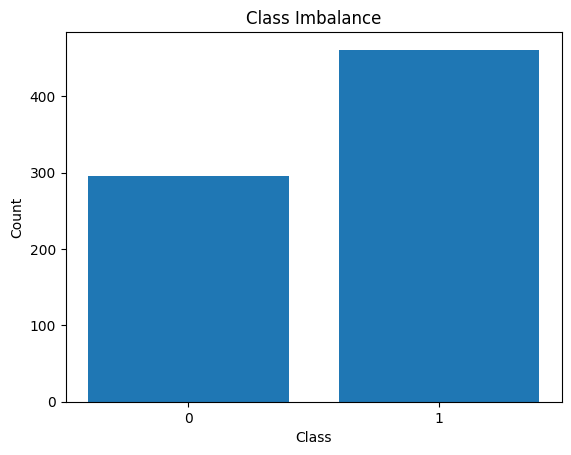

[295, 461]

In [17]:
def class_imbalance(dataset):
  y = [0] * dataset.num_classes
  for i in range(len(dataset)):
    y[dataset[i].y] += 1

  plt.bar((1,2), y)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.xticks((1,2), ('0', '1'))
  plt.title('Class Imbalance')
  plt.show()
  return y

class_imbalance(dataset)


## split data and create baches

Train size: 604
Test size: 152
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>
Number of training graphs: 604
Number of test graphs: 152
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>


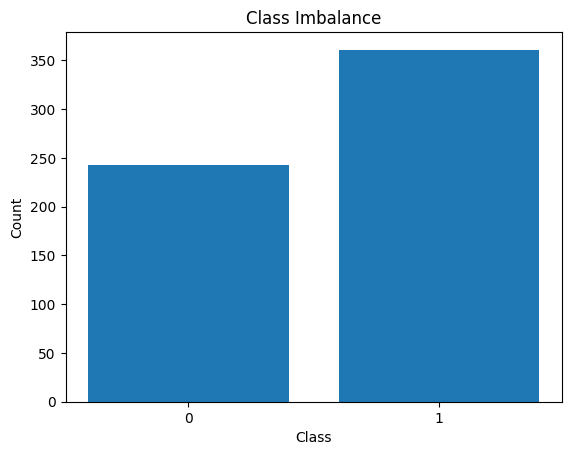

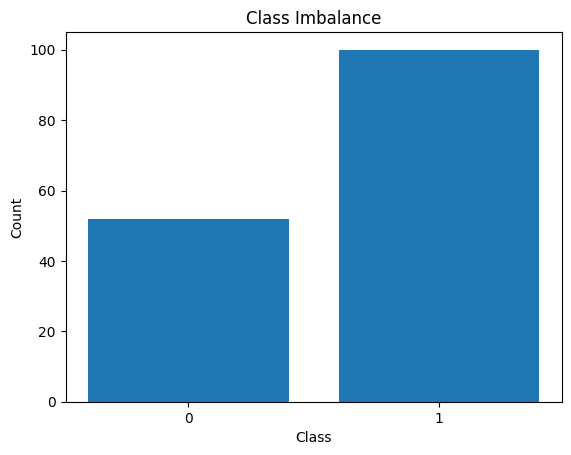

[52, 100]

In [30]:
import random

# Set seed for reproducibility
random.seed(42)

# Total dataset size
num_samples = len(dataset)

# Generate and shuffle indices
indices = list(range(num_samples))
random.shuffle(indices)

# 80/20 split
split_point = int(0.8 * num_samples)
train_indices = indices[:split_point]
test_indices = indices[split_point:]

train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

# Optional: verify
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(type(train_dataset))  # <class 'list'>

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(type(dataset))
print(type(train_dataset))
class_imbalance(train_dataset)
class_imbalance(test_dataset)


In [31]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5630], x=[2679, 53], y=[64], batch=[2679], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5662], x=[2698, 53], y=[64], batch=[2698], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5712], x=[2716, 53], y=[64], batch=[2716], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5780], x=[2751, 53], y=[64], batch=[2751], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5784], x=[2756, 53], y=[64], batch=[2756], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5854], x=[2793, 53], y=[64], batch=[2793], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5406], x=[2567, 53], y=[64], batch=[2567], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5506], x=[2615, 53], y

## GNN Exploration (in progress)

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(53, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 002, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 003, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 004, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 005, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 006, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 007, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 008, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 009, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 010, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 011, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 012, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 013, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 014, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 015, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 016, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 017, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 018, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 019, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 020, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 021, Train Acc: 0.5977, Test Acc:

In [ ]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(53, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

GNN(
  (conv1): GraphConv(53, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.4586, Test Acc: 0.3947
Epoch: 002, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 003, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 004, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 005, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 006, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 007, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 008, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 009, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 010, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 011, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 012, Train Acc: 0.6093, Test Acc: 0.6316
Epoch: 013, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 014, Train Acc: 0.6126, Test Acc: 0.6316
Epoch: 015, Train Acc: 0.6026, Test Acc: 0.6250
Epoch: 016, Train Acc: 0.6904, Test Acc: 0.6118
Epoch: 017, Train Acc: 0.6954, Test Acc: 0.6447
Epoch: 018, Train Acc: 0.6738, 

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GraphConv, global_mean_pool, global_max_pool, global_add_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, pooling='mean'):
        super(GNN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)

        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)

        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)

        self.lin = Linear(hidden_channels, dataset.num_classes)

        # Choose pooling method
        if pooling == 'mean':
            self.pool = global_mean_pool
        elif pooling == 'max':
            self.pool = global_max_pool
        elif pooling == 'add':
            self.pool = global_add_pool
        else:
            raise ValueError("pooling must be 'mean', 'max', or 'add'")

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        x = self.pool(x, batch)  # graph-level pooling

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(hidden_channels=64).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Embedding extraction function
def get_graph_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []

    for data in loader:
        data = data.to(device)
        x = model.conv1(data.x, data.edge_index)
        x = model.bn1(x)
        x = F.relu(x, inplace=True)

        x = model.conv2(x, data.edge_index)
        x = model.bn2(x)
        x = F.relu(x, inplace=True)

        x = model.conv3(x, data.edge_index)
        x = model.bn3(x)

        x = model.pool(x, data.batch)  # graph-level embeddings

        embeddings.append(x.cpu().detach())
        labels.append(data.y.cpu())

    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)


# Train function
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

# Test function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.7368, Test Acc: 0.6974
Epoch: 002, Train Acc: 0.7070, Test Acc: 0.6579
Epoch: 003, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 004, Train Acc: 0.6242, Test Acc: 0.5658
Epoch: 005, Train Acc: 0.6026, Test Acc: 0.6776
Epoch: 006, Train Acc: 0.6374, Test Acc: 0.7105
Epoch: 007, Train Acc: 0.7533, Test Acc: 0.7961
Epoch: 008, Train Acc: 0.8030, Test Acc: 0.7961
Epoch: 009, Train Acc: 0.7964, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.5977, Test Acc: 0.6579
Epoch: 011, Train Acc: 0.7715, Test Acc: 0.7434
Epoch: 012, Train Acc: 0.8146, Test Acc: 0.7171
Epoch: 013, Train Acc: 0.7384, Test Acc: 0.7566
Epoch: 014, Train Acc: 0.5844, Test Acc: 0.5658
Epoch: 015, Train Acc: 0.5265, Test Acc: 0.4737
Epoch: 016, Train Acc: 0.7103, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.8013, Test Acc: 0.6974
Epoch: 018, Train Acc: 0.7219, Test Acc: 0.6447
Epoch: 019, Train Acc: 0.7185, Test Acc: 0.7500
Epoch: 020, Train Acc: 0.8113, Test Acc: 0.7434
Epoch: 021, Train Acc: 0.8328, Test Acc:

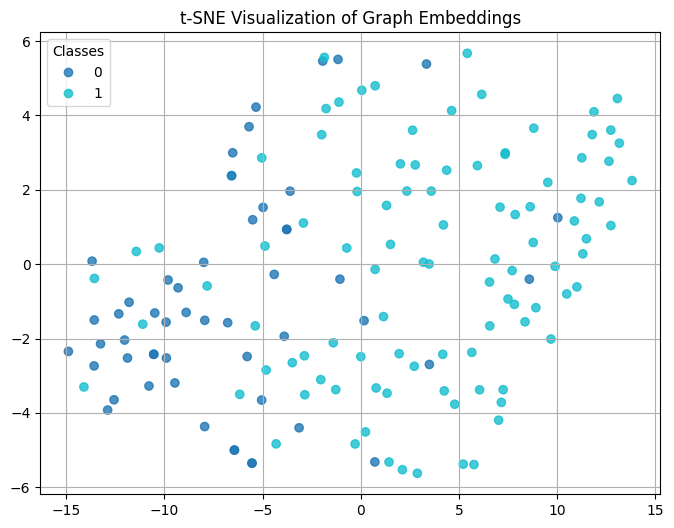

In [ ]:
# === AFTER training ===
embeddings, labels = get_graph_embeddings(model, test_loader)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings.numpy())

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Classes", loc="best")
plt.title('t-SNE Visualization of Graph Embeddings')
plt.grid(True)
plt.show()


# ----

In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset(path, name='DHFR').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [ ]:
print(dataset)

DHFR(756)


In [ ]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


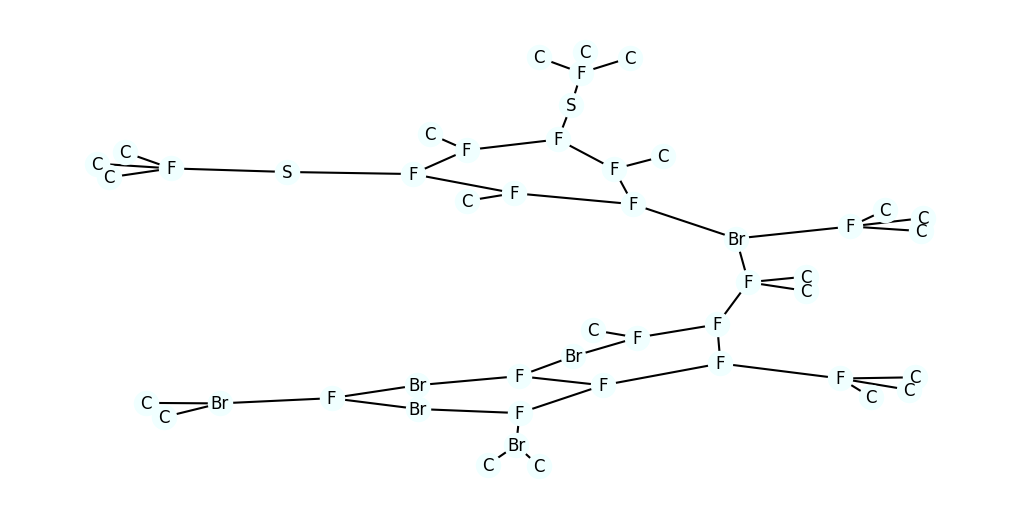

In [ ]:
import random

data = train_dataset[100]
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 10):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 1.6632, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 002, Loss: 0.8408, Train Acc: 0.5756, Test Acc: 0.5333
Epoch: 003, Loss: 0.7300, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 004, Loss: 0.7029, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 005, Loss: 0.7083, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 006, Loss: 0.6961, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 007, Loss: 0.6881, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 008, Loss: 0.6854, Train Acc: 0.6123, Test Acc: 0.5867
Epoch: 009, Loss: 0.6922, Train Acc: 0.5844, Test Acc: 0.5467


In [ ]:
!pip install -q captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 599.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

ModuleNotFoundError: No module named 'captum'

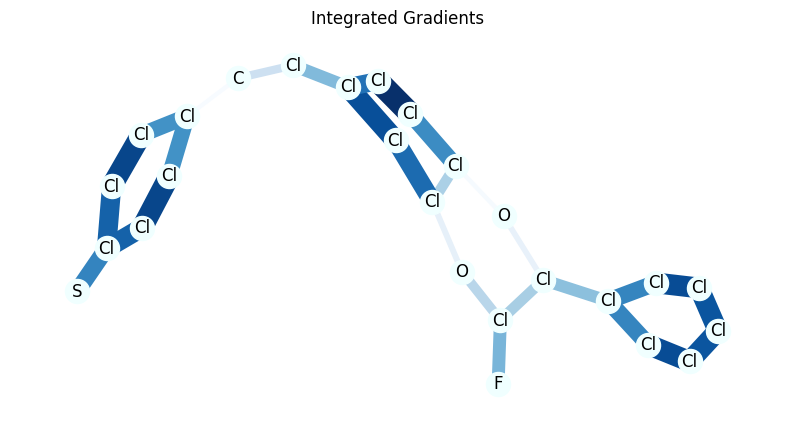

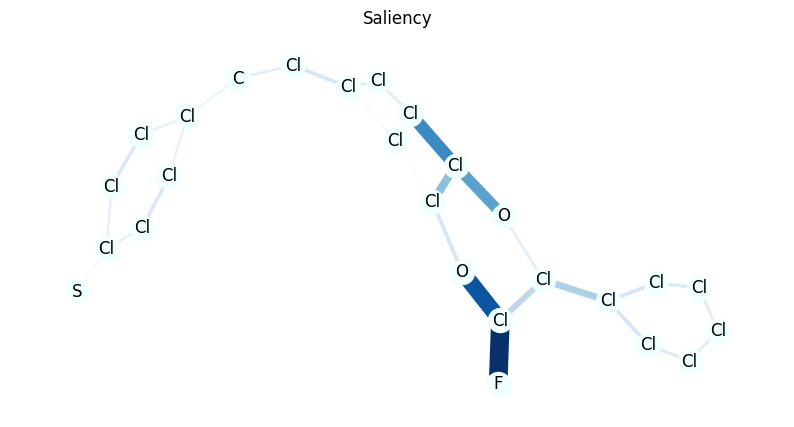

In [ ]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


data = random.choice([t for t in test_dataset if not t.y.item()])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)